This notebook demonstrates the result of our Spatial Diffusion Model (SDM). At inference, the process is: 

- Given input: $x$
- Extract the semantic encoder: $y = Enc(x)$
- Input $x$ and condition $y$ to diffusion model UNet. 
- Reconstruct the psuedo-healthy image $\hat{x}$
- Calculate the residual error $r = x - \hat{x}$

In [ ]:
# Helper function

In [1]:
%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

/home/kdang/projects/spartDM
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
from src.data.datamodules import StarmenDataset
from monai.data import DataLoader
from src.sadm.utils import plot_multi_imgs
from src.utils.metrics import percnorm, mse, mae
import json
import torch
import torch.nn.functional as F
from monai.transforms import ScaleIntensity
from einops import rearrange
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.utils.visualization import filter_gt_ano_region
import torchvision
from src.utils.visualization import plot_comparison_starmen, plot_kde_pixel, draw_featmap
from src.ldae.utils import heat_map, feature_distance, patchify
from skimage.filters import threshold_yen, threshold_otsu


from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant variables and helper functions

DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"


# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

def convert_to_torch(x, add_color_channel=True, device=torch.device("cpu")):
    """
    convert a numpy array to torch.Tensor with option to add C channel
    """
    if add_color_channel:
        x = rearrange(x, "b h w -> b 1 h w")
    x = torch.tensor(x, dtype=torch.float32).to(device)
    return x

to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Load cDDPM model

In [3]:
# CondDDPM model

from lightning.pytorch.utilities.model_summary import ModelSummary

from src.ldae import CondDDPM

## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sdm_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)

# Model summary

summary = ModelSummary(sdm_litmodel, max_depth=2)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

   | Name                      | Type               | Params | Mode 
--------------------------------------------------------------------------
0  | decoder                   | CondUNet           | 2.5 M  | train
1  | decoder.time_embed        | Sequential         | 20.7 K | train
2  | decoder.label_emb         | Linear             | 65.7 K | train
3  | decoder.input_blocks      | ModuleList         | 517 K  | train
4  | decoder.middle_block      | TimestepSequential | 469 K  | train
5  | decoder.output_blocks     | ModuleList         | 1.4 M  | train
6  | decoder.out               | Sequential         | 353    | train
7  | encoder                   | SemanticEncoder    | 24.6 M | train
8  | encoder.backbone          | BackboneBaseModule | 24.6 M | train
9  | ema_encoder               | SemanticEncoder    | 24.6 M | eval 
10 | ema_encoder.backbone      | BackboneBaseModule | 24.6 M | eval 
11 | ema_de

## Load FE model

In [4]:
# Fine-tuned feature extractor model
from src.ldae import FeatureExtractorLitmodel

## Load model
ckpt_path = os.path.join(WORK_DIR, "fe-train", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = FeatureExtractorLitmodel.load_from_checkpoint(ckpt_path, map_location=device)

fe = diffae_litmodel.fe
fe = fe.float()
fe.eval()

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

Freeze ema_encoder from DDPM models.
Delete litmodel. Only keep UNet and Encoder
  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | encoder | SemanticEncoder  | 24.6 M | eval
1 | unet    | CondUNet         | 2.5 M  | eval
2 | fe      | FeatureExtractor | 17.1 M | eval
----------------------------------------------------
8.5 M     Trainable params
27.1 M    Non-trainable params
35.6 M    Total params
142.422   Total estimated model params size (MB)
0         Modules in train mode
615       Modules in eval mode


## Data Loader

In [5]:
from monai.data import DataLoader
from monai.data.utils import first
from src.data.datamodules import StarmenDataset

train_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="train",
    nb_subject=None,
)

test_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="test",
    nb_subject=None,
)

growing_circle_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="growing_circle20",
    nb_subject=None,
)

train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=1)

# one_batch = first(iter(train_loader))

test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)

growing_circle_loader = DataLoader(growing_circle_ds, batch_size=1, shuffle=True, num_workers=1)

darker_line_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="darker_line20",
    nb_subject=None,
)
darker_line_loader = DataLoader(darker_line_ds, batch_size=1, shuffle=True, num_workers=1)

darker_circle_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="darker_circle20",
    nb_subject=None,
)
darker_circle_loader = DataLoader(darker_circle_ds, batch_size=1, shuffle=True, num_workers=1)

# Combined dataset
combine_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="test_combine",
    nb_subject=None,
)
combine_loader = DataLoader(combine_ds, batch_size=1, shuffle=True, num_workers=1)

# Combine dataset

In [9]:
# Reload the data 
import json

split = "test_combine"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

# Test dataset
combine_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
)
combine_loader = DataLoader(combine_ds, batch_size=1, shuffle=True, num_workers=1)
print(f"Len of test dataset: {len(combine_loader)}")


# Read the reconstruction error files to get the index and corresponding reonconstruction image
try: 
    eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
    with open(eval_result_file, "r") as f:
        eval_dict = json.load(f)
    test_ids = eval_dict["IDs"]
    anomaly_types = eval_dict["anomalyType"]
    print("Load from eval_dict")
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
except FileNotFoundError:
    test_ids = test_ds.ids


# Load the original (anomalious) image from test dataset by index
x_orgs = [combine_ds.get_images_by_id(id, ano)["img"].squeeze() for id, ano in zip(test_ids, anomaly_types)]
x_orgs = np.stack(x_orgs).astype("float32")

# Load the groundtruth anomaly mask 
x_ano_gts = []
for id, ano in zip(test_ids, anomaly_types):
    x_ano_gt = combine_ds.get_images_by_id(id, ano)["anomaly_gt_seg"]

    if x_ano_gt is None:
        # x_ano_gt = torch.zeros(10, 1, 64, 64)
        x_ano_gts.append(torch.zeros(10, 64, 64))
    else:
        x_ano_gts.append(x_ano_gt.squeeze())

if len(x_ano_gts) > 0: 
    x_ano_gts = np.stack(x_ano_gts).astype("float32")
    x_ano_gts.shape

# Load the original healthy images
# healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
x_hts = []
for id in test_ids:
    for t in range(0, 10):
        ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
        ht = np.load(ht_path)
        x_hts.append(ht)
x_hts = np.stack(x_hts)
x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
x_hts.shape

# add C dimension
x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")
x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")

# # Load reconstruction - xT_inferred
# x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
# x_recons.shape

# Load reconstruction - from random noise
x_recons = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
x_recons.shape

# convert to torch

x_orgs_all = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
x_hts_all = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
x_recons_all = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons
# x_ano_gts_all = to_torch(x_ano_gts) if not isinstance(x_ano_gts, torch.Tensor) else x_ano_gts
x_ano_gts_all = torch.abs(x_orgs_all - x_hts_all)
thrs = threshold_yen(x_ano_gts_all.numpy())
x_ano_gts_all = (x_ano_gts_all > thrs).float()


# Pixel distance
pixel_d = torch.abs(x_orgs_all - x_recons_all)
print(pixel_d.shape)

# Get patient meta data from dataloader
ages = []
for id, ano in zip(test_ids, anomaly_types):
    age = combine_ds.get_images_by_id(id, ano)["age"]
    ages.append(to_torch(age))

ages = torch.stack(ages)
ages.shape

Len of test dataset: 210
Load from eval_dict
torch.Size([210, 10, 1, 64, 64])


torch.Size([210, 10])

In [10]:
# Sanity check
print(x_orgs_all.shape)
print(x_recons_all.shape)
print(pixel_d.shape)

torch.Size([210, 10, 1, 64, 64])
torch.Size([210, 10, 1, 64, 64])
torch.Size([210, 10, 1, 64, 64])


## Plot reconstruction result from SDM

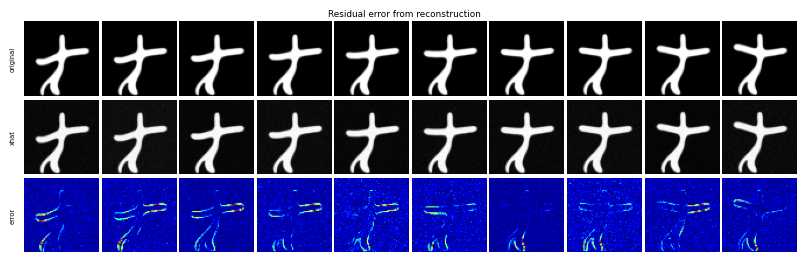

In [12]:
p_idx = 10
# timepoints = np.arange(1, 5)
# timepoints = [0, 1, 4, 7]
timepoints = np.arange(0, 10)

# original image
x = x_orgs_all[p_idx][timepoints]
x_hat = x_recons_all[p_idx][timepoints]
diff = torch.abs(x - x_hat)

# Plot
fig = plot_comparison_starmen(
    imgs=[x.squeeze(),
          x_hat.squeeze(),
          diff.squeeze(),
          ],
    labels=["original", "xhat", "error", "yen seg", "gt ano", "join seg", "ground truth"],
    is_errors=[False, False, True, True, False, True, False],
    same_cbar=False,
    opt={
        "title": "Residual error from reconstruction",
        "base_size": 1}
)

# Feature Extractor (FE) network 

torch.Size([10, 256, 16, 16])


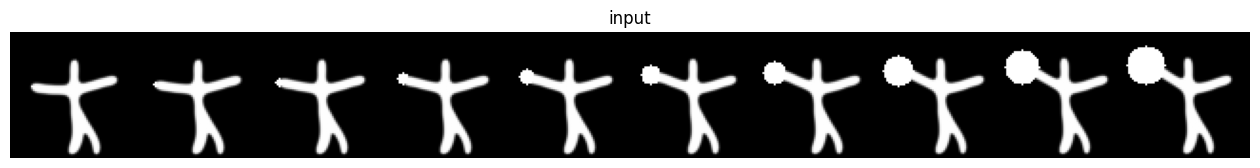

In [67]:
from src.utils.visualization import draw_featmap

# Choose 1 example
i = 165
x0 = x_orgs_all[i]

quick_plot_tensor(x0, "input")

# Run 1 pass through semantic encoder
out_frozen_fe, out_fe = fe(x0, fe_layers=["layer1", "layer2", "layer3"])
print(out_fe[0].shape)

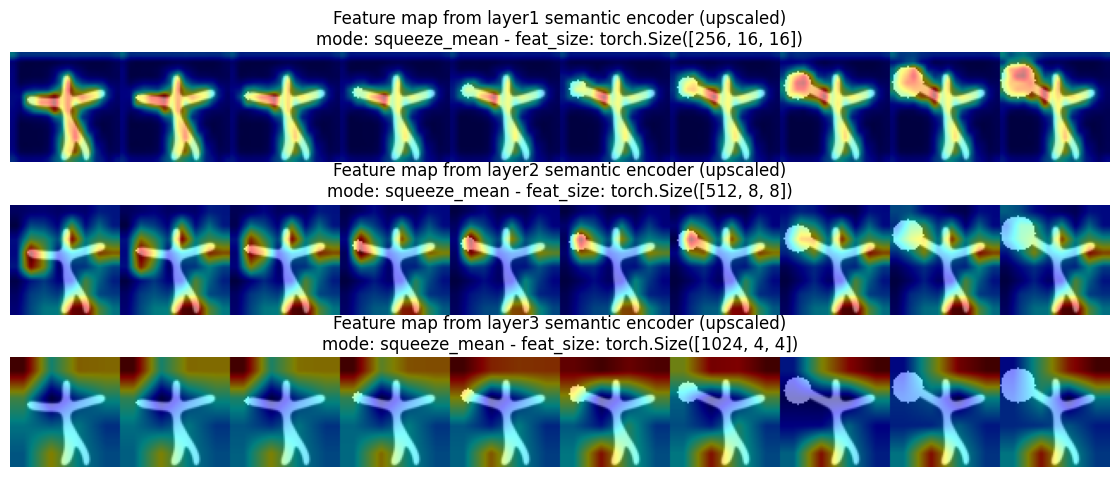

In [68]:


# Plot all feature maps from layer1 to layer3

fig, axes = plt.subplots(len(out_fe), 1, figsize=(10*1.2, 4*1.2), sharey=True)  

for i in range(3):
    ax = axes[i]
    layer = out_fe[i]

    imgs = []

    for feat, overlay in zip(layer, x0): 

        # print(feat.shape)

        # use interpolation to upscale feature map
        # feat_up = F.interpolate(feat.unsqueeze(1), size=64, mode='bilinear', align_corners=True)
        img = draw_featmap(featmap=feat, overlaid_image=overlay)
        imgs.append(img)

    imgs = np.stack(imgs)
    imgs = rearrange(imgs, "b h w c -> h (b w) c")

    ax.imshow(imgs)
    ax.set_title(f"Feature map from layer{i+1} semantic encoder (upscaled)\nmode: squeeze_mean - feat_size: {layer[0].shape}")
    ax.axis("off")

plt.tight_layout()
plt.savefig("notebooks/temp/fe-layer.svg")
plt.show()